<a href="https://colab.research.google.com/github/alinjomaa/C.Elegan_segmentation_ML_models/blob/main/Mask_RCNN_Detectron2_C_Elegan_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## synthetic image generation

In [ ]:
import cv2
import numpy as np
import os
import random
from skimage.util import random_noise

In [ ]:
import os, json
import cv2
import numpy as np
\
ASSET_FOLDER = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/assets"
OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic"
IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
MASKS_DIR = os.path.join(OUTPUT_DIR, "annotations")

NUM_IMAGES_TO_GENERATE = 1000
IMAGE_SIZE = (1024, 1024)
WORMS_PER_IMAGE = (5, 25)


CHECKPOINT_EVERY = 10
SAVE_INSTANCE_ID_MASKS = True

POLY_EPS = 1.5


PARALLEL_PLACEMENT_PROB = 0.7
LATERAL_PX_RANGE = (8.0, 25.0)
LONGITUDINAL_PX_RANGE = (-30.0, 30.0)
PLACEMENT_ATTEMPTS = 60


BG_BASE = 128
BG_NOISE_SIGMA = 6



def load_assets(asset_folder):
    asset_library = []
    if not os.path.exists(asset_folder):
        raise FileNotFoundError(f"ASSET_FOLDER not found: {asset_folder}")

    for fname in os.listdir(asset_folder):
        if not fname.lower().endswith(".png"):
            continue

        fpath = os.path.join(asset_folder, fname)
        img_rgba = cv2.imread(fpath, cv2.IMREAD_UNCHANGED)

        if img_rgba is None or img_rgba.ndim != 3 or img_rgba.shape[2] != 4:
            print(f"Warning: Skipping {fname} (not valid RGBA PNG)")
            continue

        alpha = img_rgba[:, :, 3]
        mask = (alpha > 0).astype(np.uint8)

        if mask.sum() == 0:
            print(f"Warning: Skipping {fname} (empty mask)")
            continue

        asset_library.append((img_rgba, mask))

    print(f"Loaded {len(asset_library)} assets from {asset_folder}")
    if not asset_library:
        raise RuntimeError("No valid RGBA assets loaded. Check ASSET_FOLDER.")
    return asset_library



class BackgroundFactory:
    def __init__(self, H, W):
        self.H, self.W = H, W
        kx = cv2.getGaussianKernel(W, int(W * 0.7))
        ky = cv2.getGaussianKernel(H, int(H * 0.7))
        kernel = ky @ kx.T
        mask = kernel / (kernel.max() + 1e-8)
        self.vignette = (mask[..., None] * 255).astype(np.uint8)

    def make(self, base=128, noise_sigma=6):
        bg = np.full((self.H, self.W, 3), base, dtype=np.uint8)
        noise = np.zeros_like(bg, dtype=np.int16)
        cv2.randn(noise, 0, noise_sigma)
        bg = np.clip(bg.astype(np.int16) + noise, 0, 255).astype(np.uint8)

        vig3 = np.repeat(self.vignette, 3, axis=2)
        return cv2.addWeighted(bg, 0.75, vig3, 0.25, 0)


def alpha_blend_inplace(bg, fg_rgba, x, y):
    h, w = fg_rgba.shape[:2]
    roi = bg[y:y+h, x:x+w]

    alpha = fg_rgba[:, :, 3:4].astype(np.float32) / 255.0
    fg = fg_rgba[:, :, :3].astype(np.float32)
    rb = roi.astype(np.float32)

    out = fg * alpha + rb * (1.0 - alpha)
    roi[:] = out.astype(np.uint8)



def elastic_transform_cv2(img, mask, alpha=50.0, sigma=8.0, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    H, W = img.shape[:2]
    dx = rng.uniform(-1, 1, size=(H, W)).astype(np.float32)
    dy = rng.uniform(-1, 1, size=(H, W)).astype(np.float32)

    dx = cv2.GaussianBlur(dx, (0, 0), sigma) * alpha
    dy = cv2.GaussianBlur(dy, (0, 0), sigma) * alpha

    x, y = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32))
    map_x = x + dx
    map_y = y + dy

    img2 = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    m2   = cv2.remap(mask, map_x, map_y, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return img2, m2



def augment_instance(instance_rgba, instance_mask, rng):
    # Scale
    scale = rng.uniform(0.8, 1.5)
    h, w = instance_rgba.shape[:2]
    nh, nw = max(1, int(h * scale)), max(1, int(w * scale))

    img = cv2.resize(instance_rgba, (nw, nh), interpolation=cv2.INTER_AREA)
    msk = cv2.resize(instance_mask, (nw, nh), interpolation=cv2.INTER_NEAREST)


    angle_deg = rng.uniform(0, 360)
    center = (nw / 2.0, nh / 2.0)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)

    cos = abs(M[0, 0]); sin = abs(M[0, 1])
    rw = int(nh * sin + nw * cos)
    rh = int(nh * cos + nw * sin)
    M[0, 2] += (rw / 2.0) - center[0]
    M[1, 2] += (rh / 2.0) - center[1]

    img = cv2.warpAffine(img, M, (rw, rh), flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))
    msk = cv2.warpAffine(msk, M, (rw, rh), flags=cv2.INTER_NEAREST,
                         borderMode=cv2.BORDER_CONSTANT, borderValue=0)


    if rng.random() < 0.5:
        img, msk = elastic_transform_cv2(img, msk, alpha=50, sigma=8, rng=rng)


    if rng.random() < 0.7:
        brightness = rng.uniform(0.8, 1.2)
        contrast = rng.uniform(0.9, 1.1)
        bgr = img[:, :, :3].astype(np.float32)
        bgr = np.clip(bgr * contrast + (brightness - 1.0) * 30.0, 0, 255)
        img[:, :, :3] = bgr.astype(np.uint8)

    # Blur
    if rng.random() < 0.5:
        k = int(rng.choice([3, 5]))
        img[:, :, :3] = cv2.GaussianBlur(img[:, :, :3], (k, k), 0)

    return img, msk


def propose_pos_random(H, W, w, h, rng):
    if w > W or h > H:
        return None
    x = int(rng.integers(0, W - w + 1))
    y = int(rng.integers(0, H - h + 1))
    return x, y

def propose_pos_parallel(anchor, w, h, base_angle, rng):
    ang = base_angle + rng.uniform(-np.pi/12, np.pi/12)  # ±15°
    perp = ang + np.pi/2

    side = rng.choice([-1.0, 1.0])
    lateral = side * rng.uniform(LATERAL_PX_RANGE[0], LATERAL_PX_RANGE[1])
    longitudinal = rng.uniform(LONGITUDINAL_PX_RANGE[0], LONGITUDINAL_PX_RANGE[1])

    cx = anchor["cx"] + lateral * np.cos(perp) + longitudinal * np.cos(ang)
    cy = anchor["cy"] + lateral * np.sin(perp) + longitudinal * np.sin(ang)

    x = int(cx - w / 2)
    y = int(cy - h / 2)
    return x, y


def generate(IMAGES_DIR, MASKS_DIR, ASSET_FOLDER):
    os.makedirs(IMAGES_DIR, exist_ok=True)
    os.makedirs(MASKS_DIR, exist_ok=True)

    asset_library = load_assets(ASSET_FOLDER)

    H, W = IMAGE_SIZE
    bg_factory = BackgroundFactory(H, W)
    rng = np.random.default_rng(0)

    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "worm"}]
    }
    ann_id = 1

    for i in range(NUM_IMAGES_TO_GENERATE):
        if i % 25 == 0:
            print(f"Scene {i}/{NUM_IMAGES_TO_GENERATE}")

        scene = bg_factory.make(base=BG_BASE, noise_sigma=BG_NOISE_SIGMA)
        instance_id_map = np.zeros((H, W), dtype=np.uint16)

        placed_meta = []
        num_worms = int(rng.integers(WORMS_PER_IMAGE[0], WORMS_PER_IMAGE[1] + 1))
        base_angle = rng.uniform(0, 2*np.pi)

        for _ in range(num_worms):
            inst_rgba, inst_mask = asset_library[int(rng.integers(0, len(asset_library)))]
            aug_rgba, aug_mask = augment_instance(inst_rgba, inst_mask, rng)
            h, w = aug_rgba.shape[:2]

            # Ensure fits
            if w > W or h > H:
                scale = min(W / w, H / h)
                nw, nh = max(1, int(w * scale)), max(1, int(h * scale))
                aug_rgba = cv2.resize(aug_rgba, (nw, nh), interpolation=cv2.INTER_AREA)
                aug_mask = cv2.resize(aug_mask, (nw, nh), interpolation=cv2.INTER_NEAREST)
                h, w = nh, nw

            placed = False
            for _attempt in range(PLACEMENT_ATTEMPTS):
                if placed_meta and rng.random() < PARALLEL_PLACEMENT_PROB:
                    anchor = placed_meta[int(rng.integers(0, len(placed_meta)))]
                    x, y = propose_pos_parallel(anchor, w, h, base_angle, rng)
                else:
                    pos = propose_pos_random(H, W, w, h, rng)
                    if pos is None:
                        break
                    x, y = pos

                if x < 0 or y < 0 or x + w > W or y + h > H:
                    continue

                placed = True
                break

            if not placed:
                continue


            alpha_blend_inplace(scene, aug_rgba, x, y)

            worm_bin = (aug_mask > 0).astype(np.uint8)
            instance_id = len(placed_meta) + 1
            roi = instance_id_map[y:y+h, x:x+w]
            roi[worm_bin > 0] = instance_id


            cnts, _ = cv2.findContours(worm_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for c in cnts:
                if len(c) < 3:
                    continue
                c = c.copy()
                c[:, 0, 0] += x
                c[:, 0, 1] += y

                if POLY_EPS and POLY_EPS > 0:
                    c2 = cv2.approxPolyDP(c, POLY_EPS, True)
                else:
                    c2 = c

                if len(c2) < 3:
                    continue

                seg = c2.flatten().tolist()
                x0, y0, bw, bh = cv2.boundingRect(c2)
                area = float(cv2.contourArea(c2))

                coco["annotations"].append({
                    "id": ann_id,
                    "image_id": i,
                    "category_id": 1,
                    "segmentation": [seg],
                    "area": area,
                    "bbox": [int(x0), int(y0), int(bw), int(bh)],
                    "iscrowd": 0
                })
                ann_id += 1

            placed_meta.append({"cx": x + w/2, "cy": y + h/2, "w": w, "h": h})


        fname = f"hybrid_final_{i:04d}.png"
        cv2.imwrite(os.path.join(IMAGES_DIR, fname), scene)
        coco["images"].append({"id": i, "file_name": fname, "width": W, "height": H})


        if SAVE_INSTANCE_ID_MASKS:
            inst_path = os.path.join(MASKS_DIR, f"inst_{i:04d}.png")
            cv2.imwrite(inst_path, instance_id_map.astype(np.uint16))


        if CHECKPOINT_EVERY and ((i + 1) % CHECKPOINT_EVERY == 0):
            partial_path = os.path.join(MASKS_DIR, "annotations_partial.json")
            with open(partial_path, "w") as f:
                json.dump(coco, f)


    final_path = os.path.join(MASKS_DIR, "annotations.json")
    with open(final_path, "w") as f:
        json.dump(coco, f)

    print(f"Done. Images: {len(coco['images'])}, Annotations: {ann_id - 1}")
    print(f"Wrote: {final_path}")
    if CHECKPOINT_EVERY:
        print(f"Also wrote periodic checkpoints: {os.path.join(MASKS_DIR, 'annotations_partial.json')}")
    if SAVE_INSTANCE_ID_MASKS:
        print(f"Saved instance-id masks to: {MASKS_DIR}/inst_XXXX.png")


generate(IMAGES_DIR=IMAGES_DIR, MASKS_DIR=MASKS_DIR, ASSET_FOLDER=ASSET_FOLDER)



Loaded 50 assets from /content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/assets
Scene 0/1000
Scene 25/1000
Scene 50/1000
Scene 75/1000
Scene 100/1000
Scene 125/1000
Scene 150/1000
Scene 175/1000
Scene 200/1000
Scene 225/1000
Scene 250/1000
Scene 275/1000
Scene 300/1000
Scene 325/1000
Scene 350/1000
Scene 375/1000
Scene 400/1000
Scene 425/1000
Scene 450/1000
Scene 475/1000
Scene 500/1000
Scene 525/1000
Scene 550/1000
Scene 575/1000
Scene 600/1000
Scene 625/1000
Scene 650/1000
Scene 675/1000
Scene 700/1000
Scene 725/1000
Scene 750/1000
Scene 775/1000
Scene 800/1000
Scene 825/1000
Scene 850/1000
Scene 875/1000
Scene 900/1000
Scene 925/1000
Scene 950/1000
Scene 975/1000
Done. Images: 1000, Annotations: 16401
Wrote: /content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations.json
Also wrote periodic checkpoints: /content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations_partial.json
Saved instance-id ma

Visualizing image: hybrid_final_0514.png
Found 20 worm instances


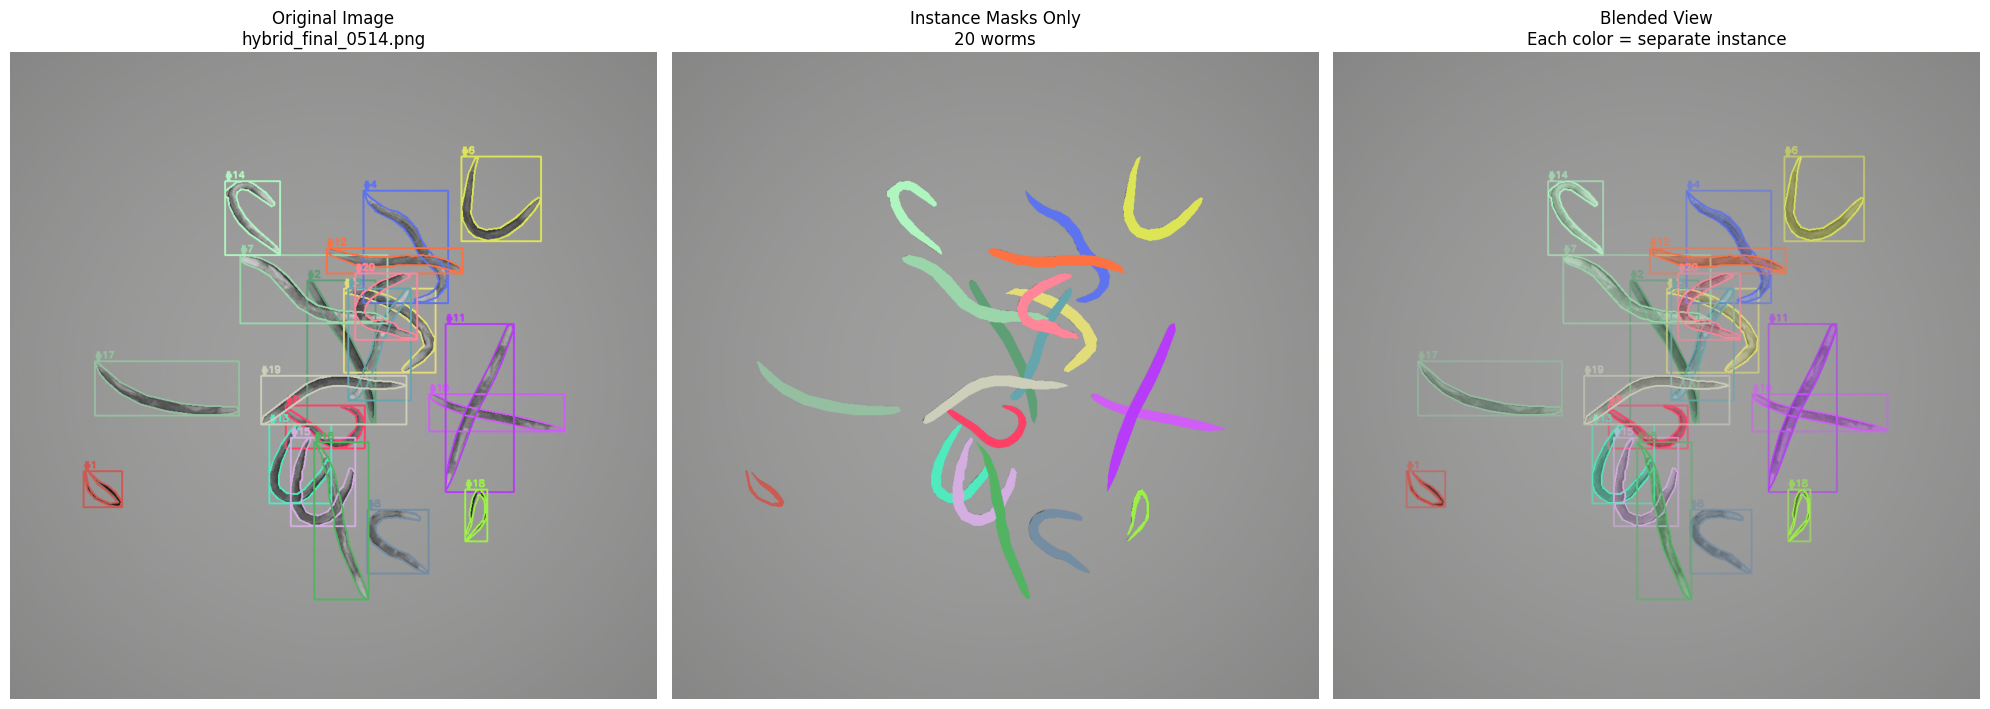


 Each worm has a unique color - no merging
Total annotations in dataset: 16401


In [ ]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the annotations
with open("/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations.json", 'r') as f:
    coco_data = json.load(f)

# Pick a random image to visualize
image_idx = random.randint(0, len(coco_data['images']) - 1)
image_info = coco_data['images'][image_idx]

# Load the image
img_path = f"/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/images/{image_info['file_name']}"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create overlay
overlay = image.copy()

# Get all annotations for this image
annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_idx]

print(f"Visualizing image: {image_info['file_name']}")
print(f"Found {len(annotations)} worm instances")

# Draw each annotation with a different random color
for idx, ann in enumerate(annotations):
    # Random bright color for each worm
    color = (random.randint(50, 255), random.randint(50, 255), random.randint(50, 255))

    # Get segmentation polygon
    segmentation = ann['segmentation'][0]
    points = np.array(segmentation).reshape(-1, 2).astype(np.int32)

    # Draw filled polygon
    cv2.fillPoly(overlay, [points], color)

    # Draw outline
    cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)

    # Draw bounding box
    x, y, w, h = ann['bbox']
    cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), color, 2)

    # Add instance ID text
    cv2.putText(image, f"#{idx+1}", (int(x), int(y)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Blend original image with colored overlay
blended = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)

# Display
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title(f"Original Image\n{image_info['file_name']}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(overlay)
plt.title(f"Instance Masks Only\n{len(annotations)} worms")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title("Blended View\nEach color = separate instance")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n Each worm has a unique color - no merging")
print(f"Total annotations in dataset: {len(coco_data['annotations'])}")

##Import detectron2

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Install Detectron 2

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 25.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15943, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 15943 (delta 5), reused 4 (delta 4), pack-reused 15931 (from 3)
Receiving objects: 100% (15943/15943), 6.70 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (11337/11337), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environ

## Setup and Train Model

In [ ]:
# Import torch and detectron 2
import torch, detectron2
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
# Import necessary Libraries/modules
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.data.transforms import ResizeShortestEdge
from detectron2.data.detection_utils import read_image, annotations_to_instances, transform_instance_annotations
from detectron2.data import DatasetMapper


In [ ]:
import json
from detectron2.data import DatasetCatalog, MetadataCatalog

# Unregister all datasets first
for dataset_name in ["my_dataset_train", "my_dataset_val", "my_dataset_synthetic", "my_new_dataset_name"]:
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)


json_path = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2_annotations/_annotations.coco.json"
with open(json_path, 'r') as f:
    data = json.load(f)

data['categories'] = [{"id": 1, "name": "worm"}]


with open(json_path, 'w') as f:
    json.dump(data, f)

# Now register normally
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/worm_segmentation/annotations_cleaned.json", "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/annotations/val.json", "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/val")
register_coco_instances("my_dataset_synthetic", {}, "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations.json", "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/images")
register_coco_instances("my_new_dataset_name", {}, "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2_annotations/_annotations.coco.json", "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2")

In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")


[02/03 22:22:49 d2.data.datasets.coco]: Loaded 197 images in COCO format from /content/drive/MyDrive/worm_segmentation/annotations_cleaned.json


In [ ]:
new_dataset_metadata = MetadataCatalog.get("my_new_dataset_name")
new_dataset_dicts = DatasetCatalog.get("my_new_dataset_name")

[02/03 22:22:50 d2.data.datasets.coco]: Loaded 429 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2_annotations/_annotations.coco.json


In [ ]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[02/03 22:22:53 d2.data.datasets.coco]: Loaded 3 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/annotations/val.json


In [ ]:
synthetic_metadata = MetadataCatalog.get("my_dataset_synthetic")
synthetic_dataset_dicts = DatasetCatalog.get("my_dataset_synthetic")

[02/03 22:22:54 d2.data.datasets.coco]: Loaded 1000 images in COCO format from /content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/new_synthetic/annotations/annotations.json


In [ ]:
# import plotting/vizualization library
from matplotlib import pyplot as plt

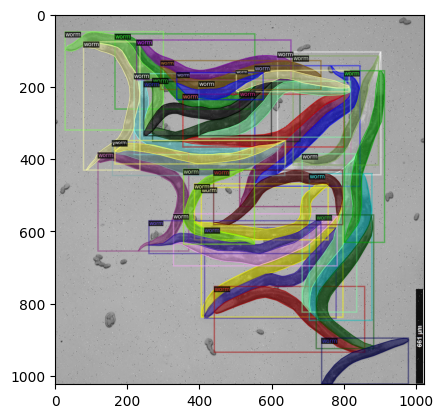

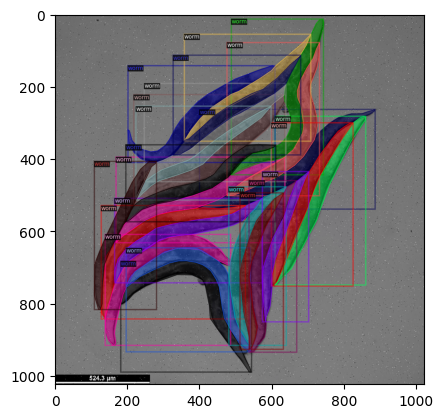

In [ ]:
#Vizualize Random Sample
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [ ]:
import torch
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train", "my_dataset_synthetic", "my_new_dataset_name")
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 6000
cfg.SOLVER.STEPS = (4000, 5500)
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.AMP.ENABLED = True
cfg.SOLVER.CHECKPOINT_PERIOD = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.INPUT.MIN_SIZE_TRAIN = (640, 768, 896)
cfg.INPUT.MAX_SIZE_TRAIN = 1024
cfg.INPUT.MIN_SIZE_TEST = 768
cfg.INPUT.MAX_SIZE_TEST = 1024
cfg.INPUT.RANDOM_FLIP = "horizontal"
cfg.TEST.EVAL_PERIOD = 500

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[02/03 23:02:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_480dd8.pkl: 288MB [00:14, 20.1MB/s]                           
roi_heads.box_predictor.0.cls_score.{bias, weight}
roi_heads.box_predictor.1.cls_score.{bias, weight}
roi_heads.box_predictor.2.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
# Start Training
trainer.train()

[02/03 23:02:41 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[02/03 23:02:47 d2.utils.events]:  eta: 0:21:54  iter: 19  total_loss: 5.944  loss_cls_stage0: 0.6671  loss_box_reg_stage0: 0.542  loss_cls_stage1: 0.7028  loss_box_reg_stage1: 0.7926  loss_cls_stage2: 0.7264  loss_box_reg_stage2: 0.7542  loss_mask: 0.6954  loss_rpn_cls: 0.8888  loss_rpn_loc: 0.2481    time: 0.2946  last_time: 0.2409  data_time: 0.0525  last_data_time: 0.0152   lr: 4.9953e-06  max_mem: 3463M
[02/03 23:02:52 d2.utils.events]:  eta: 0:21:55  iter: 39  total_loss: 5.62  loss_cls_stage0: 0.6594  loss_box_reg_stage0: 0.4765  loss_cls_stage1: 0.6815  loss_box_reg_stage1: 0.8222  loss_cls_stage2: 0.6959  loss_box_reg_stage2: 0.7457  loss_mask: 0.6763  loss_rpn_cls: 0.491  loss_rpn_loc: 0.2115    time: 0.2623  last_time: 0.2180  data_time: 0.0184  last_data_time: 0.0088   lr: 9.9902e-06  max_mem: 3463M
[02/03 23:02:56 d2.utils.events]:  eta: 0:21:57  iter: 59  total_loss: 5.437  loss_cls_stage0: 0.6274  loss_box_reg_stage0: 0.5619  loss_cls_stage1: 0.6449  loss_box_reg_stage1:

## Total Loss Analysis

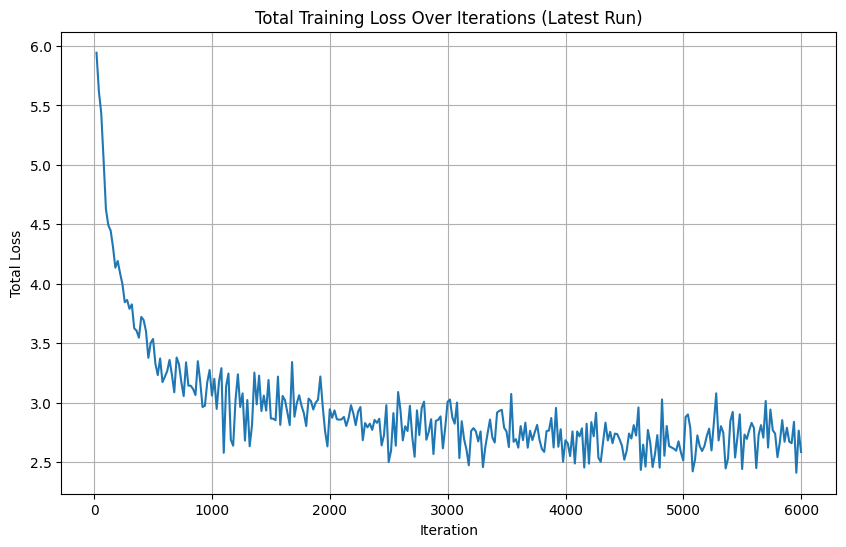

In [ ]:
import json
import matplotlib.pyplot as plt
import os


metrics_path = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
all_metrics = []
with open(metrics_path, 'r') as f:
    for line in f:
        try:
            all_metrics.append(json.loads(line))
        except json.JSONDecodeError:

            continue
start_index = 0
if len(all_metrics) > 1:
    for i in range(1, len(all_metrics)):
        current_iter = all_metrics[i].get('iteration')
        prev_iter = all_metrics[i-1].get('iteration')


        if current_iter is not None and prev_iter is not None and current_iter < prev_iter:
            start_index = i
latest_run_metrics = all_metrics[start_index:]

iterations = [m['iteration'] for m in latest_run_metrics if 'total_loss' in m]
total_losses = [m['total_loss'] for m in latest_run_metrics if 'total_loss' in m]

# Plot the total training loss for the latest run
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_losses)
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.title('Total Training Loss Over Iterations (Latest Run)')
plt.grid(True)
plt.show()

##Model Inference

In [ ]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[02/03 23:28:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


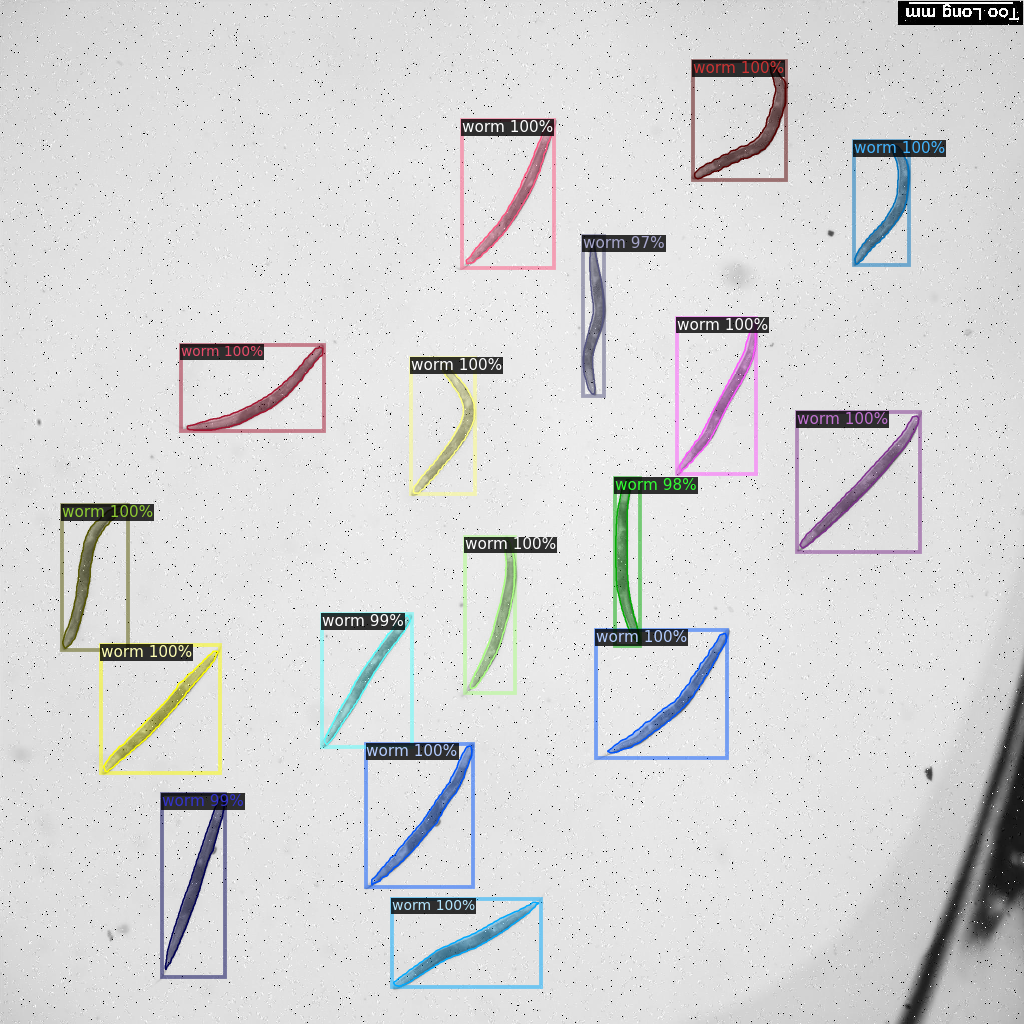

In [ ]:
from detectron2.utils.visualizer import ColorMode
import cv2
import random

for d in random.sample(train_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])

    outputs = predictor(im)

    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


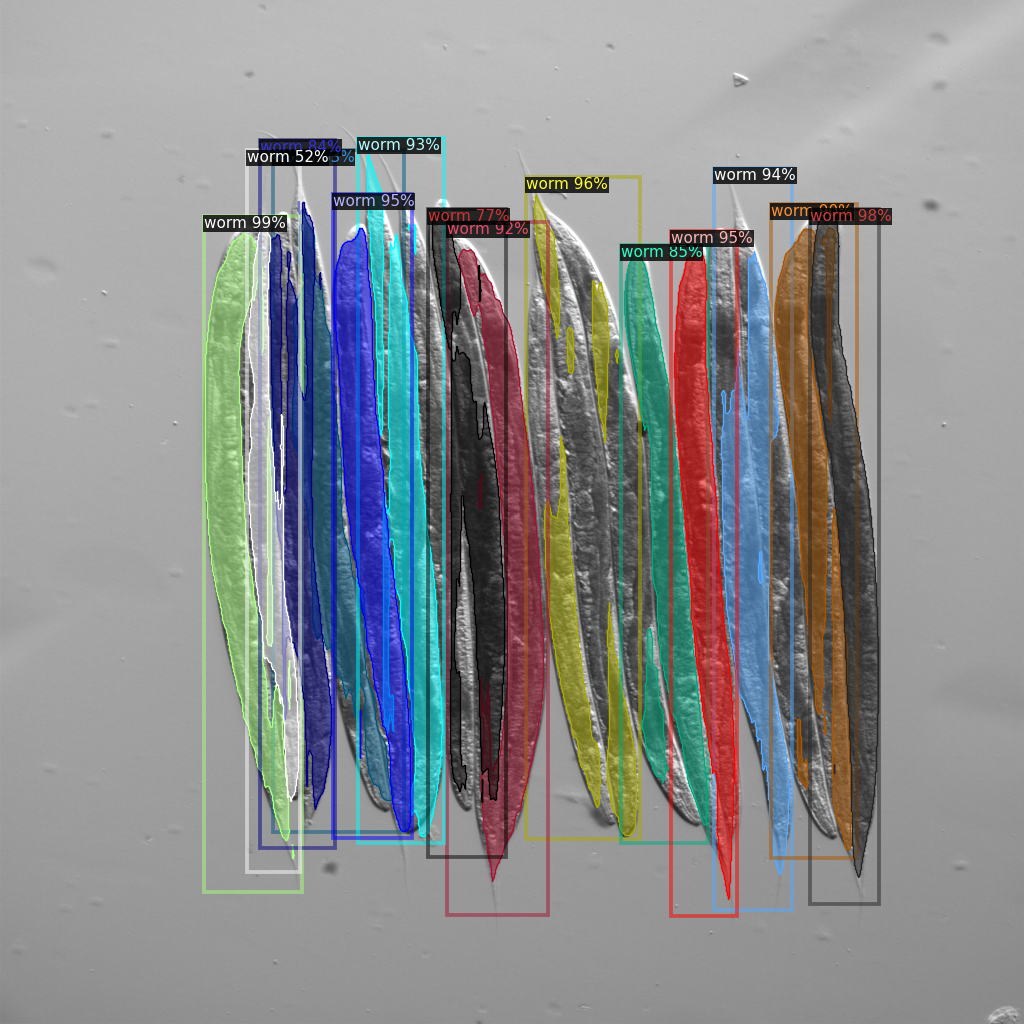

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/test/5 10 50 mM smells fed and sDR.lif_fed day 7_ch02.tif")
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])


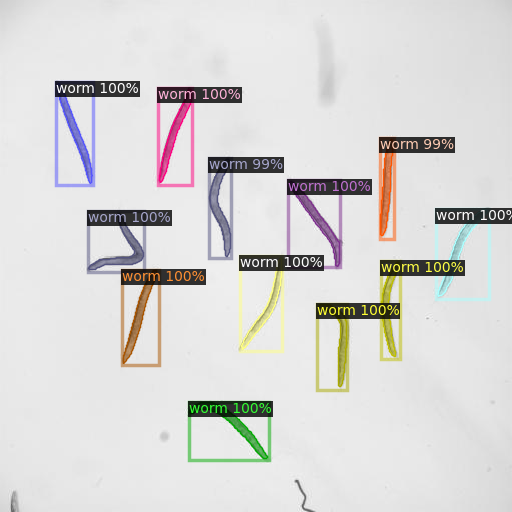

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/train2/All-conditions_C10_1_ch00_jpg.rf.21ea92f772a2e14e26e706bb8d8e1be7.jpg")
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

##Fluorescence analysis function and Inference

In [ ]:
import numpy as np
import cv2
import pandas as pd
import os
from google.colab import drive
from google.colab.patches import cv2_imshow


drive.mount('/content/drive')


output_dir = "/content/drive/MyDrive/worm_analysis_results"
os.makedirs(output_dir, exist_ok=True)

def analyze_worms_fluorescence(gray, fluor, masks, save_overlay=True, heatmap=False):

    results = []

    combined_mask = np.zeros_like(fluor, dtype=bool)
    for m in masks:
        combined_mask |= m


    background_pixels = fluor[~combined_mask]
    background = np.median(background_pixels)


    fluor_corr = np.clip(fluor - background, 0, None)


    if heatmap:

        heatmap_img = cv2.applyColorMap(fluor_corr.astype(np.uint8), cv2.COLORMAP_JET)
        overlay_img = cv2.addWeighted(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 0.5, heatmap_img, 0.5, 0)
    else:

        overlay_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        for mask in masks:
            overlay_img[mask] = (0, 255, 0)


    for worm_id, mask in enumerate(masks):
        worm_pixels = fluor_corr[mask]
        fluor_pixels_nonzero = worm_pixels[worm_pixels > 0]
        mean_intensity = float(np.mean(fluor_pixels_nonzero)) if fluor_pixels_nonzero.size > 0 else 0
        area = int(mask.sum())

        results.append({
            "worm_id": worm_id,
            "area_pixels": area,
            "mean_fluor": mean_intensity
        })


    df = pd.DataFrame(results)
    csv_path = os.path.join(output_dir, "worm_fluorescence_results.csv")
    df.to_csv(csv_path, index=False)


    if save_overlay:
        overlay_name = "worm_fluorescence_overlay_heatmap.png" if heatmap else "worm_fluorescence_overlay_green.png"
        overlay_path = os.path.join(output_dir, overlay_name)
        cv2.imwrite(overlay_path, overlay_img)
        print(f"Overlay image saved to {overlay_path}")

    print(f"Analysis complete. CSV saved to {csv_path}")
    return df, overlay_img




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Overlay image saved to /content/drive/MyDrive/worm_analysis_results/worm_fluorescence_overlay_heatmap.png
Analysis complete. CSV saved to /content/drive/MyDrive/worm_analysis_results/worm_fluorescence_results.csv
Fluorescence analysis results per worm:


worm_id  area_pixels  mean_fluor
0         0         1403   36.112616
1         1        28306   15.715054
2         2         5912   26.419824
3         3         2664   38.483859
4         4        61017   30.111891
5         5        72864    7.837187
6         6        60629   26.861568
7         7            0    0.000000
8         8         5536   17.446712
9         9        44738   13.373655
10       10         9575   31.674047


Overlay heatmap:


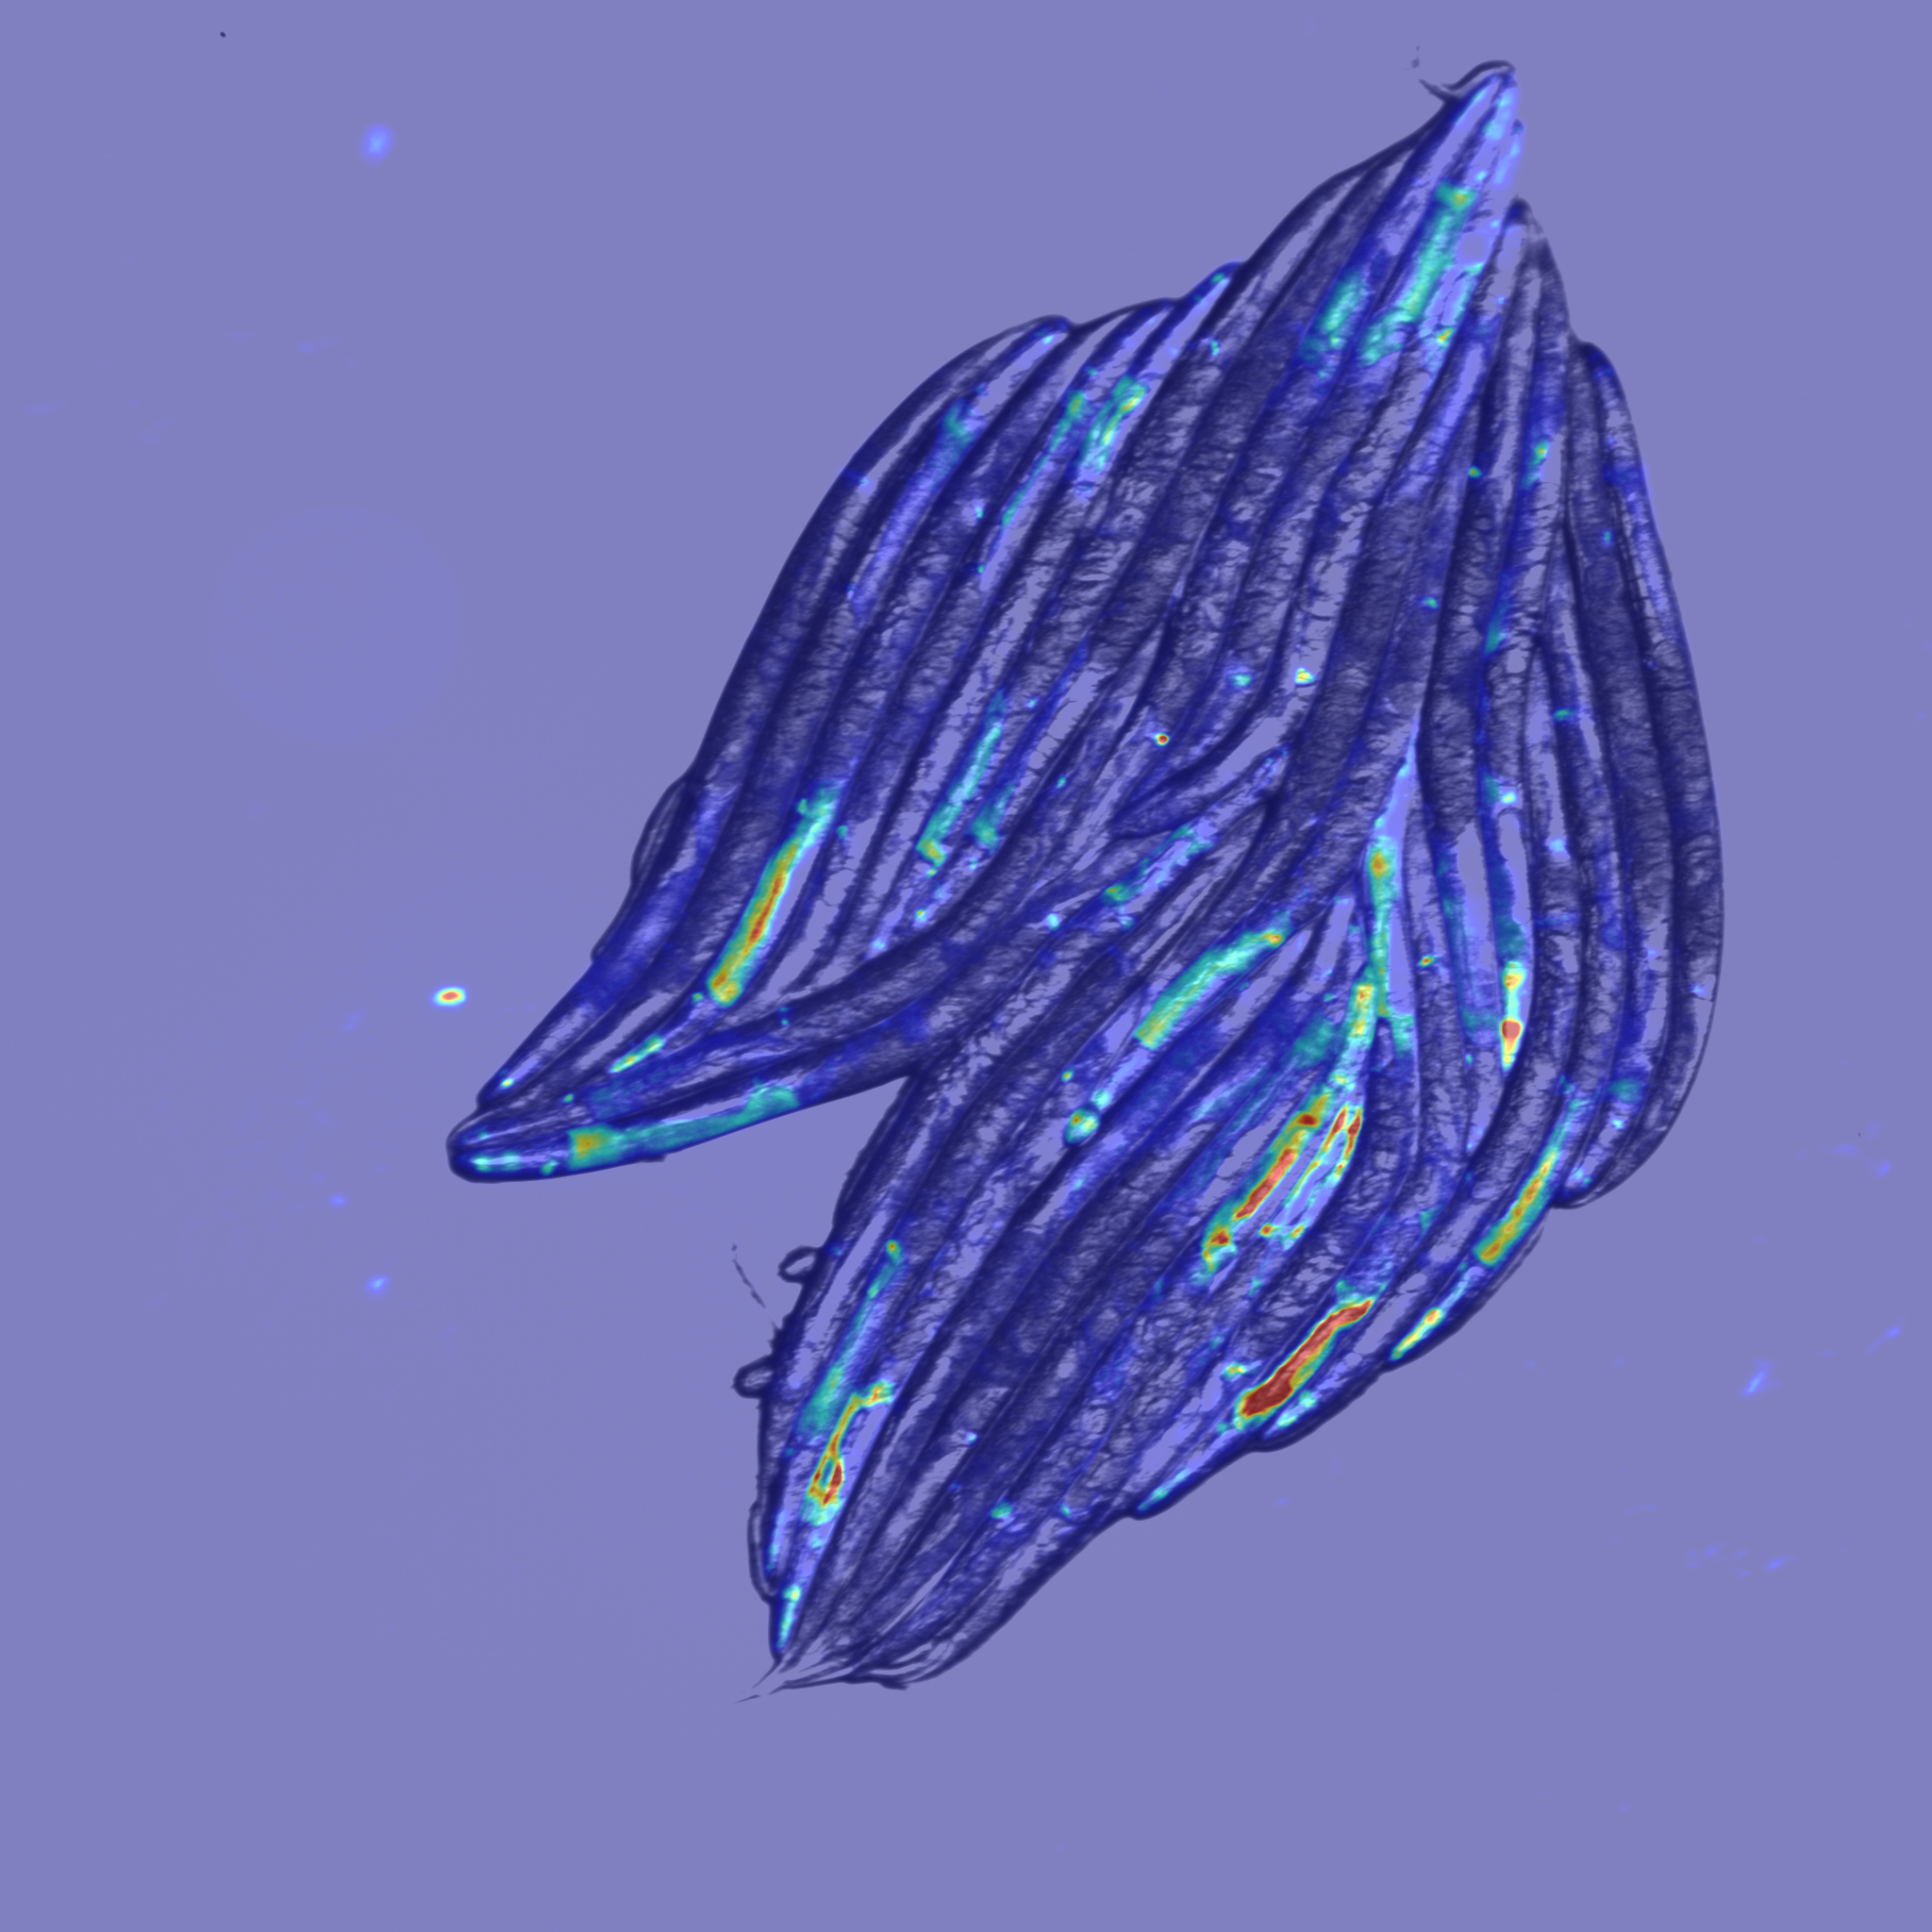

In [ ]:

seg_image_path = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/flour-gray/Image006_RAW_ch00.tif"
fluor_image_path = "/content/drive/MyDrive/ColabNotebooks/data/worm_segmentation/flour-gray/Image006_ch02.jpg"


gray = cv2.imread(seg_image_path, cv2.IMREAD_GRAYSCALE)


fluor_bgr = cv2.imread(fluor_image_path, cv2.IMREAD_COLOR)
fluor = fluor_bgr[:, :, 2]


outputs = predictor(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR))
masks_tensor = outputs["instances"].pred_masks.to("cpu")
masks = [m.numpy().astype(bool) for m in masks_tensor]


df, overlay_img = analyze_worms_fluorescence(gray, fluor, masks, save_overlay=True, heatmap=True)


print("Fluorescence analysis results per worm:")
display(df)

print("\nOverlay heatmap:")
cv2_imshow(overlay_img)


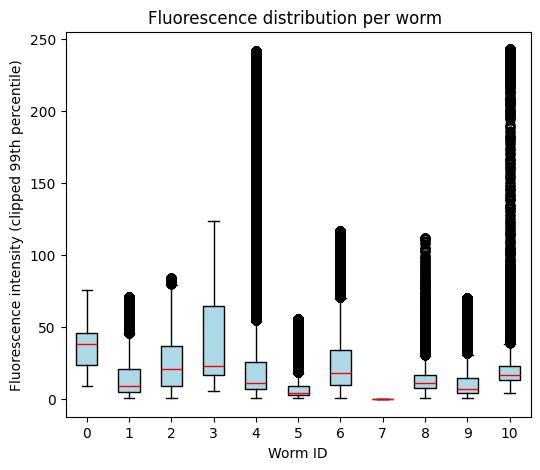

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

combined_mask = np.zeros_like(fluor, dtype=bool)
for m in masks:
    combined_mask |= m

background_pixels = fluor[~combined_mask]
background = np.median(background_pixels)
fluor_corr = np.clip(fluor - background, 0, None)

worm_intensities = []
for worm_id, mask in enumerate(masks):
    pixels = fluor_corr[mask]
    pixels_nonzero = pixels[pixels > 0]
    if pixels_nonzero.size > 0:
        max_val = np.percentile(pixels_nonzero, 99)
        pixels_nonzero = np.clip(pixels_nonzero, 0, max_val)
        worm_intensities.append(pixels_nonzero)
    else:
        worm_intensities.append([0])

plt.figure(figsize=(max(6, len(masks)*0.5), 5))
plt.boxplot(
    worm_intensities,
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="red")
)
plt.xlabel("Worm ID")
plt.ylabel("Fluorescence intensity (clipped 99th percentile)")
plt.title("Fluorescence intensity distribution per worm ")
plt.xticks(ticks=range(1, len(masks)+1), labels=range(len(masks)))
plt.show()
